# Exercise with A/B Testing

### Prompt

Let’s imagine you work on the For You Page at TikTok. Your team decides that instead of a heart button, they want to change it to star hoping that it will lead to a higher engagement/like rate. The product manager told you that the current conversion rate is about 6% on average throughout the year, and that the team would be happy with an increase of 3%, meaning that the new design will be considered a success if it raises the engagement rate to 9%.

Before rolling out the change, the team would be more comfortable testing it on a small number of users to see how it performs, so you suggest running an A/B test on a subset of the user base users.

In [35]:
# Packages imports
import numpy as np
import pandas as pd

# probability distributions & statistical functions
import scipy.stats as stats
# estimating statistical models
import statsmodels.stats.api as sms

import matplotlib.pyplot as plt
import seaborn as sns

#rounding function
from math import ceil

sns.set()

### Sample Size Calculation

In [36]:
# Calculate effect size based on our expected rates

effect_size = sms.proportion_effectsize(0.06,0.09)

print(effect_size)

-0.11445118168989954


In [37]:
# Calculate sample size needed
required_n = sms.NormalIndPower().solve_power(
    effect_size,
    power = 0.8,
    alpha = 0.05,
    ratio = 1)

required_n = ceil(required_n)
print(required_n)

1199


### Collecting and preparing the data

In [56]:
# Load the tiktok_data.csv into a dataframe
df = pd.read_csv('data/tiktok_data.csv')


In [57]:
# Get the info of the dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275781 entries, 0 to 275780
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    275781 non-null  int64 
 1   timestamp  275781 non-null  object
 2   group      275781 non-null  object
 3   button     275781 non-null  object
 4   liked      275781 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 10.5+ MB


In [58]:
# Check that no users have been sampled multiple times 
session_counts = df['user_id'].value_counts()
multi_users = session_counts[session_counts > 1].count()
print(multi_users)

3453


In [59]:
# If there are users who have been sampled multiple times, remove them from the dataframe
print(df.shape)
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(df.shape)

(275781, 5)
(268875, 5)


In [60]:
# Make sure all the control group are seeing the star button and viceversa

pd.crosstab(df['group'], df['button'])

button,heart,star
group,,
control,134233,110
treatment,109,134423


In [61]:
df_control = df[(df['group'] == 'control')].copy()

df_control = df_control[df.button != 'star'].copy()

df_treat = df[(df['group'] == 'treatment')].copy()
df_treat = df_treat[df.button != 'heart'].copy()

df_clean = pd.concat([df_control, df_treat], ignore_index = True)

df = df_clean.copy()
df.shape

C:\Users\conor\AppData\Local\Temp\ipykernel_4520\1964610018.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_control = df_control[df.button != 'star'].copy()
C:\Users\conor\AppData\Local\Temp\ipykernel_4520\1964610018.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_treat = df_treat[df.button != 'heart'].copy()


(268656, 5)

In [62]:
df.head()

,user_id,timestamp,group,button,liked
0,746742,2017-01-23 11:38:30,control,heart,0
1,913579,2017-01-24 9:11:39,control,heart,1
2,690284,2017-01-13 17:22:57,control,heart,0
3,710349,2017-01-11 22:24:44,control,heart,0
4,677533,2017-01-23 17:48:50,control,heart,0


In [63]:
pd.crosstab(df['group'], df['button'])

button,heart,star
group,,
control,134233,0
treatment,0,134423


#### Now that our DataFrame is nice and clean, we can proceed and sample n=4720 entries for each of the groups. We can use pandas' DataFrame.sample() method to do this, which will perform Simple Random Sampling for us.

In [74]:
# Perform simple random sampling to split the data into control and treatment

control_sample = df[df['group'] == 'control'].sample(n = 4720, random_state = 444)
treatment_sample = df[df['group'] == 'treatment'].sample(n = 4720, random_state = 444)
control_sample.head()


,user_id,timestamp,group,button,liked
22391,923141,2017-01-22 5:57:47,control,heart,0
86483,672677,2017-01-06 23:30:47,control,heart,0
45074,830874,2017-01-18 23:10:33,control,heart,0
14799,824896,2017-01-19 17:45:24,control,heart,0
132122,689786,2017-01-15 12:54:08,control,heart,0


In [75]:
treatment_sample.head()

,user_id,timestamp,group,button,liked
151487,668931,2017-01-08 14:38:29,treatment,star,1
158612,940674,2017-01-04 19:09:07,treatment,star,0
178344,688387,2017-01-14 22:06:15,treatment,star,0
141883,842372,2017-01-18 11:50:59,treatment,star,0
220241,934270,2017-01-10 23:31:42,treatment,star,0


In [76]:
# Create one table called ab_test that has both the cleaned control and treatment data

ab_test = pd.concat([control_sample, treatment_sample], axis = 0)
ab_test.reset_index(drop = True, inplace = True)
ab_test


,user_id,timestamp,group,button,liked
0,923141,2017-01-22 5:57:47,control,heart,0
1,672677,2017-01-06 23:30:47,control,heart,0
2,830874,2017-01-18 23:10:33,control,heart,0
3,824896,2017-01-19 17:45:24,control,heart,0
4,689786,2017-01-15 12:54:08,control,heart,0
...,...,...,...,...,...
9435,906522,2017-01-17 17:52:05,treatment,star,1
9436,915194,2017-01-23 9:06:12,treatment,star,0
9437,839155,2017-01-09 19:13:09,treatment,star,0
9438,763360,2017-01-10 17:23:58,treatment,star,0


In [77]:
# Count the test groups to make sure that they're balanced 
ab_test['group'].value_counts()


control      4720
treatment    4720
Name: group, dtype: int64

### Analysis Visualization

In [91]:
# Find the like rate by group
summary_stats = ab_test.groupby('group')['liked'].agg(['std','mean','sem','sum','count'])
summary_stats = summary_stats.reset_index()
summary_stats
# Find the Std. deviation of the proportion
#summary_stats['std']

# Find the Std. error of the proportion (std / sqrt(n))
#summary_stats['sem']

# Calculate the final like rate


,group,std,mean,sem,sum,count
0,control,0.320381,0.116102,0.004663,548,4720
1,treatment,0.330754,0.125000,0.004814,590,4720


In [92]:
like_rates = summary_stats['sum'] / summary_stats['count']
like_rates
# 0 == control
# 1 == treatment

0    0.116102
1    0.125000
dtype: float64

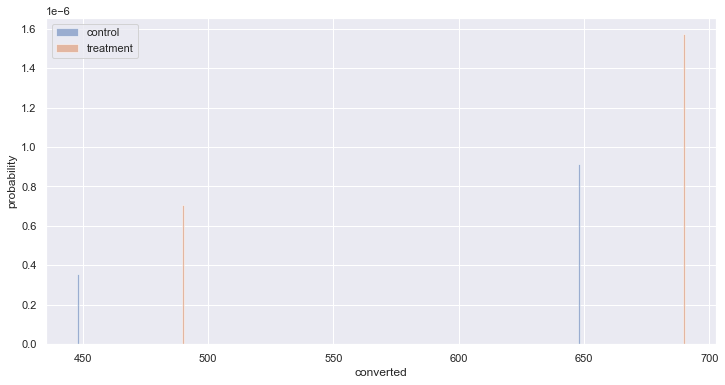

In [96]:
# Plot the like rate by group on a bar plot
import scipy.stats as scs
# seperate control and treatment rows
control_selector = summary_stats['group'] == 'control'
treatment_selector = summary_stats['group'] == 'treatment'

# number of observations
control_total = summary_stats[control_selector]['count'].values
treatment_total = summary_stats[treatment_selector]['count'].values

# conversion rate
control_cr = summary_stats[ control_selector]['mean'].values
treatment_cr = summary_stats[ treatment_selector]['mean'].values

# total conversions
control_converted = summary_stats[control_selector]['sum'].values
treatment_converted = summary_stats[treatment_selector]['sum'].values

#graph things
xA = np.linspace(control_converted-100, control_converted+100, 500).flatten()
yA = scs.binom(control_total, control_cr).pmf(xA).flatten()

xB = np.linspace(treatment_converted-100, treatment_converted+100, 500).flatten()
yB = scs.binom(treatment_total, treatment_cr).pmf(xB).flatten()

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(xA, yA, alpha=0.5)
ax.bar(xB, yB, alpha=0.5)


# ax.axvline(x=z.values[0], c='blue', alpha=0.75, linestyle='--')
plt.xlabel('converted')
plt.ylabel('probability')

ax.legend(['control', 'treatment'])
#yeah I don't know what happened

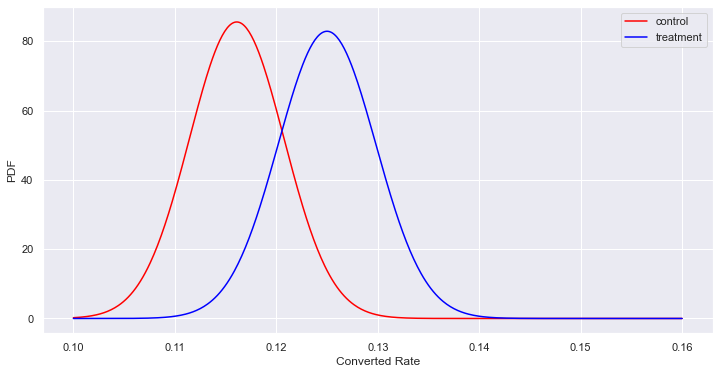

In [97]:
# standard error of the mean for both groups
SE_A = summary_stats[control_selector]['sem']
SE_B = summary_stats[treatment_selector]['sem']


# plot the null and alternative hypothesis
fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(.1, .16, 500)
yA = scs.norm(control_cr, SE_A).pdf(xA)


ax.plot(xA, yA, c='red')
#ax.axvline(x=control_cr, c='red', alpha=0.5, linestyle='--')

xB = np.linspace(0.1, .16, 500)
yB = scs.norm(treatment_cr, SE_B).pdf(xB)

ax.plot(xB, yB, c='blue')
#ax.axvline(x=B_cr, c='blue', alpha=0.5, linestyle='--')
plt.xlabel('Converted Rate')
plt.ylabel('PDF')

ax.legend(['control', 'treatment'])
#much better

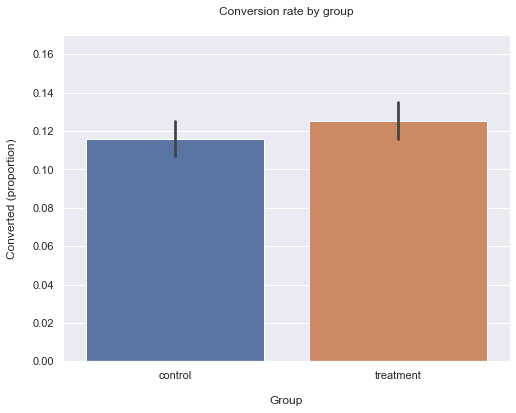

In [100]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['liked'])

plt.ylim(0, 0.17)

plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

### Testing for Stat Sig

In [107]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# Get the like count for both control and treatment groups
control_results = ab_test[ab_test['group'] == 'control']['liked']
treatment_results = ab_test[ab_test['group'] == 'treatment']['liked']


# Get the number of samples in both groups

n_con = control_results.count()
n_treat = treatment_results.count()


# Sum up the number of successes (likes) in both groups

successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

print('observation in control', control_likes)
print('observation in treatment', treatment_likes)
print('successes in control %d, and successes in treatment %d.' % (successes[0], successes[1]))

observation in control 4720
observation in treatment 4720
successes in control 548, and successes in treatment 590.


In [108]:
# Find the z statistic and p value for proportions based on normal ztest
z_stat, pval = proportions_ztest(
    successes, 
    nobs=nobs) #Test for proportions based on normal ztest

# Find the confidence intervals for each test group

(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05) #confidence interval for a binomial proportion


In [109]:
# print z statistic
print(f'z statistic: {z_stat:.2f}')
# print p-value
print(f'p-value: {pval:.6f}')
# print ci 95% for control group
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
# print ci 95% for treatment group
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -1.33
p-value: 0.184305
ci 95% for control group: [0.107, 0.125]
ci 95% for treatment group: [0.116, 0.134]


### Were the results signficant? 

In [110]:
print("the p-value is not below 0.05 so the null hypothesis H0 will be rejected")

the p-value is not below 0.05 so the null hypothesis H0 will be rejected


### What would you advise the engineering team to do moving forward?

In [111]:
print("I would advise the engineering team that the like button is not something that should be changed.")

I would advise the engineering team that the like button is not something that should be changed.


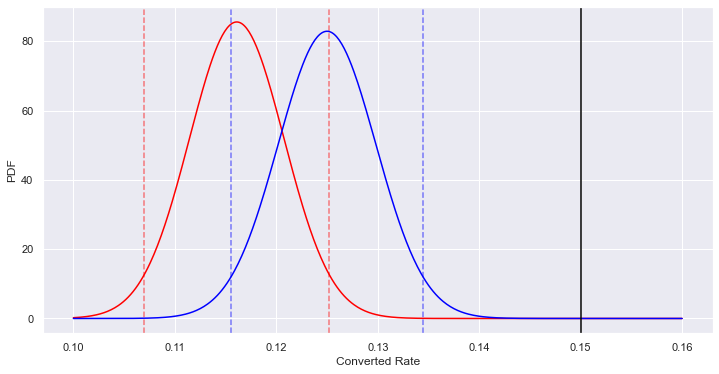

In [112]:
sns.set()
# standard error of the mean for both groups
SE_A = summary_stats[control_selector]['sem']
SE_B = summary_stats[treatment_selector]['sem']


# plot the null and alternative hypothesis
fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(.1, .16, 500)
yA = scs.norm(control_cr, SE_A).pdf(xA)


ax.plot(xA, yA, c='red')

# lower bound
ax.axvline(x=lower_con, c='red', alpha=0.5, linestyle='--')
ax.axvline(x=upper_con, c='red', alpha=0.5, linestyle='--')


xB = np.linspace(0.1, .16, 500)
yB = scs.norm(treatment_cr, SE_B).pdf(xB)
ax.plot(xB, yB, c='blue')

ax.axvline(x=lower_treat, c='blue', alpha=0.5, linestyle='--')
ax.axvline(x=upper_treat, c='blue', alpha=0.5, linestyle='--')


plt.xlabel('Converted Rate')
plt.ylabel('PDF')

ax.axvline(x=0.15, c='black')